# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import os
import re
import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.classification import GBTClassifier, LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, VectorIndexer, VectorAssembler, CountVectorizer, StringIndexer, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import seaborn as sns
import time
from plotnine import *

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .master('local[*]') \
        .appName('Sparkify') \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
data = spark.read.json('medium-sparkify-event-data.json')

In [4]:
data.count()

543705

Count missing values for all columns in the data frame

In [5]:
data.agg(*[count(when(isnull(c),1)).alias(c) for c in data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



In [6]:
#remove missing data based on user first and last names
data = data.dropna(subset=['firstName', 'lastName'])

In [7]:
data.agg(*[count(when(isnull(c),1)).alias(c) for c in data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 95128|   0|        0|     0|            0|       0| 95128|    0|       0|     0|   0|           0|        0|95128|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [8]:
# number of records
data.count()

528005

In [9]:
# number of users
data.groupby('firstName', 'lastName', 'userId').count().count()

448

After data cleaning, no missing values in firtName, lastName, userId, and sessionId.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [11]:
# types of sessions
data.select('page').distinct().show(truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Settings                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



#### Churn
There are two types of churns: 1) Cancellation of membership and 2) Downgrade from paid level to free level. We will consider both types. The first type of churn is indicated by "Cancellation Confirmation" in the session and the second type is by "Submit Downgrade" is session.

In below, churn status for each user is calculated.

In [12]:
churn = data.groupby('userId').agg(array_contains(collect_set('page'), 'Submit Downgrade').alias('churn_Downgrade'), \
    array_contains(collect_set('page'), 'Cancellation Confirmation').alias('churn_Cancel')) \
.select('userId', col('churn_Downgrade').cast(IntegerType()), col('churn_Cancel').cast(IntegerType()))
churn.show(5)

+------+---------------+------------+
|userId|churn_Downgrade|churn_Cancel|
+------+---------------+------------+
|   296|              0|           1|
|100010|              0|           1|
|200002|              0|           1|
|   125|              0|           0|
|   124|              0|           1|
+------+---------------+------------+
only showing top 5 rows



In [13]:
churn.crosstab('churn_Cancel', 'churn_Downgrade').show()

+----------------------------+---+---+
|churn_Cancel_churn_Downgrade|  0|  1|
+----------------------------+---+---+
|                           1| 78| 21|
|                           0|273| 76|
+----------------------------+---+---+



#### Session length, Number of items per session and Number of songs per session

For each user, mean and standard deviation of the length of session, number of items in seesion and number of songs are calcualted as numberical features.

In [14]:
# for each user:
# average and stdev of sessnion_length (in seconds), 
# avg and stdev of number of songs per session
session_length_items_songs = data.groupby('userId', 'sessionId') \
.agg(((max('ts')-min('ts'))/1000).alias('session_length'), \
     count('sessionId').alias('n_items'), \
     sum((col('page') == 'NextSong').cast(IntegerType())).alias('n_songs')
    ) \
.groupby('userId') \
.agg(avg('session_length').alias('session_len_avg'), \
     stddev_samp('session_length').alias('session_len_std'), \
     avg('n_items').alias('n_items_avg'), \
     stddev_samp('n_items').alias('n_items_std'), \
     avg('n_songs').alias('n_songs_session_avg'), stddev_samp('n_songs').alias('n_songs_session_std') \
    ).fillna(0)
session_length_items_songs.show(5)

+------+-----------------+------------------+-----------+------------------+-------------------+-------------------+
|userId|  session_len_avg|   session_len_std|n_items_avg|       n_items_std|n_songs_session_avg|n_songs_session_std|
+------+-----------------+------------------+-----------+------------------+-------------------+-------------------+
|200002|          15783.6|10575.341568951804|       79.0|46.238512086787566|               62.0| 38.255718526777144|
|   296|           5822.2|5305.3528346378625|       30.4| 29.57701810527897|               22.4|   19.3597520645281|
|100010|          12622.5| 1034.497220875919|       68.5|0.7071067811865476|               48.0| 1.4142135623730951|
|   125|           5099.0|    6812.256307568|       28.0| 33.77869150810907| 20.666666666666668|  28.00595174839329|
|     7|7630.333333333333|7398.2147428249455|       40.0| 35.63505497199552|               30.8| 29.265289044483104|
+------+-----------------+------------------+-----------+-------

#### Thumb Up, Thumb Down, Add Friend, Roll Advert, Add to Playlist,  Submit Upgrade, Error

Features related to user transactions in the column Page. The ratio of the number of interactions and the total number of interactions for each user is calculated for Thumb Up, Thumb Down, Add Friend, Roll Advert, Add to Playlist, Submit Upgrade, Error.

In [15]:
##for each user,compute the portion of a given action of all actions

portions = data.groupby('userId') \
.agg((sum((col('page')=='Thumbs Up' ).cast(IntegerType()))/count('page')).alias('thumb_up_ratio'), \
     (sum((col('page')=='Thumbs Down' ).cast(IntegerType()))/count('page')).alias('thumb_down_ratio') , \
     (sum((col('page')=='Add Friend' ).cast(IntegerType()))/count('page')).alias('add_friend_ratio') , \
     (sum((col('page')=='Roll Advert' ).cast(IntegerType()))/count('page')).alias('roll_advert_ratio') , \
     (sum((col('page')=='Add to Playlist' ).cast(IntegerType()))/count('page')).alias('add_palylist_ratio') , \
     (sum((col('page')=='Submit Upgrade' ).cast(IntegerType()))/count('page')).alias('submit_upgrade_ratio') , \
     (sum((col('page')=='Error' ).cast(IntegerType()))/count('page')).alias('error_ratio') , \
)
portions.show(5,truncate=False)

+------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+
|userId|thumb_up_ratio      |thumb_down_ratio    |add_friend_ratio    |roll_advert_ratio   |add_palylist_ratio   |submit_upgrade_ratio|error_ratio         |
+------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+
|296   |0.05263157894736842 |0.0                 |0.013157894736842105|0.05921052631578947 |0.019736842105263157 |0.006578947368421052|0.0                 |
|100010|0.029197080291970802|0.021897810218978103|0.021897810218978103|0.16058394160583941 |0.0072992700729927005|0.0                 |0.0                 |
|200002|0.0379746835443038  |0.012658227848101266|0.005063291139240506|0.027848101265822784|0.015189873417721518 |0.002531645569620253|0.0                 |
|125   |0.03571428571428571 |0.011904761904761904|0.035714

#### Gender, Device and transaction status

In [16]:
## Device of user
def DeviceType(s):
    try:
        s = s.lower()
    except:
        s=''
    result = 'None'
    if ('windows nt' in s) or ('compatible' in s):
        result = 'Windows'
    if 'x11' in s:
        result = 'X11'
    if 'ipad' in s:
        result = 'iPad'
    if 'iphone' in s:
        result = 'iPhone'
    if 'macintosh' in s:
        result = 'Mac'
    return result
device = udf(DeviceType, StringType())  

#For each user:
# gender
# device used to access sparkify
# time lapse between latest transaction and registration (in days)
#whether contains 404 web status
gender_device_time_status = data.groupby('userId') \
.agg(first('gender').alias('gender'), \
     device(first('userAgent')).alias('device'), \
     ((max('ts')-avg('registration'))/1000/3600/24).alias('time'), \
     array_contains(collect_set('status'), 404).cast(IntegerType()).alias('status_404') \
)

gender_device_time_status.show(5)

+------+------+------+------------------+----------+
|userId|gender|device|              time|status_404|
+------+------+------+------------------+----------+
|   296|     F|   Mac| 26.63826388888889|         0|
|100010|     F|iPhone|14.328449074074074|         0|
|200002|     M|iPhone| 53.32314814814814|         0|
|   125|     M|   Mac|105.42211805555554|         0|
|   124|     F|   Mac| 112.5537962962963|         0|
+------+------+------+------------------+----------+
only showing top 5 rows



#### Combine All Features into One Data Frame

In [17]:
#transoform: onehotencoding for gender
#churn
#portions
#session_length_items_songs
#gender_device_time_status
df = churn.join(portions, on='userId') \
          .join(session_length_items_songs, on='userId') \
          .join(gender_device_time_status, on='userId')

In [18]:
df.count()

448

In [19]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn_Downgrade: integer (nullable = true)
 |-- churn_Cancel: integer (nullable = true)
 |-- thumb_up_ratio: double (nullable = true)
 |-- thumb_down_ratio: double (nullable = true)
 |-- add_friend_ratio: double (nullable = true)
 |-- roll_advert_ratio: double (nullable = true)
 |-- add_palylist_ratio: double (nullable = true)
 |-- submit_upgrade_ratio: double (nullable = true)
 |-- error_ratio: double (nullable = true)
 |-- session_len_avg: double (nullable = false)
 |-- session_len_std: double (nullable = false)
 |-- n_items_avg: double (nullable = false)
 |-- n_items_std: double (nullable = false)
 |-- n_songs_session_avg: double (nullable = false)
 |-- n_songs_session_std: double (nullable = false)
 |-- gender: string (nullable = true)
 |-- device: string (nullable = true)
 |-- time: double (nullable = true)
 |-- status_404: integer (nullable = true)



### Data Expolartion

Check if there is any correlation between churn and feature variables

#### Categorical Features

If appears that cancellation churn rate is hihger for male but downgrade churn rate is lower for male users:

In [20]:
df.crosstab('churn_Cancel', 'gender').show()

+-------------------+---+---+
|churn_Cancel_gender|  F|  M|
+-------------------+---+---+
|                  1| 45| 54|
|                  0|153|196|
+-------------------+---+---+



In [21]:
df.crosstab('churn_Downgrade', 'gender').show()

+----------------------+---+---+
|churn_Downgrade_gender|  F|  M|
+----------------------+---+---+
|                     1| 46| 51|
|                     0|152|199|
+----------------------+---+---+



It appears that cancel churn rate is higher when 404 rate is lower but downgrade churn rate is higher when 404 rate is higher.

In [22]:
df.crosstab('churn_Cancel', 'status_404').show()

+-----------------------+---+---+
|churn_Cancel_status_404|  0|  1|
+-----------------------+---+---+
|                      1| 59| 40|
|                      0|166|183|
+-----------------------+---+---+



In [23]:
df.crosstab('churn_Downgrade', 'status_404').show()

+--------------------------+---+---+
|churn_Downgrade_status_404|  0|  1|
+--------------------------+---+---+
|                         1| 27| 70|
|                         0|198|153|
+--------------------------+---+---+



In [24]:
#device
df.crosstab('churn_Cancel', 'device').show()

+-------------------+---+-------+---+----+------+
|churn_Cancel_device|Mac|Windows|X11|iPad|iPhone|
+-------------------+---+-------+---+----+------+
|                  1| 35|     48|  5|   0|    11|
|                  0|138|    174| 21|   9|     7|
+-------------------+---+-------+---+----+------+



In [25]:
df.crosstab('churn_Downgrade', 'device').show()

+----------------------+---+-------+---+----+------+
|churn_Downgrade_device|Mac|Windows|X11|iPad|iPhone|
+----------------------+---+-------+---+----+------+
|                     1| 37|     45|  7|   2|     6|
|                     0|136|    177| 19|   7|    12|
+----------------------+---+-------+---+----+------+



#### Continuous Features

Distributions of continuous features for churn and non-churn groups are compared. Correlation between the features is analyzed to remove some of the highly correlated features.

In [26]:
params = ['thumb_up_ratio',
 'thumb_down_ratio',
 'add_friend_ratio',
 'roll_advert_ratio',
 'add_palylist_ratio',
 'submit_upgrade_ratio',
 'error_ratio',
 'session_len_avg',
 'session_len_std',
 'time']

In [27]:
df.select(*(params+['churn_Cancel'])).groupby('churn_Cancel').agg({p:'mean' for p in params}).collect()

[Row(churn_Cancel=1, avg(thumb_up_ratio)=0.039791181423047786, avg(add_friend_ratio)=0.014471172925169683, avg(roll_advert_ratio)=0.040880366689801446, avg(add_palylist_ratio)=0.02081255591524812, avg(thumb_down_ratio)=0.01083540837399207, avg(submit_upgrade_ratio)=0.0011168263550515546, avg(session_len_avg)=17451.207411462936, avg(time)=67.96801989805464, avg(session_len_std)=14958.45668260582, avg(error_ratio)=0.0006449270849316139),
 Row(churn_Cancel=0, avg(thumb_up_ratio)=0.04330325117489644, avg(add_friend_ratio)=0.015738068017301533, avg(roll_advert_ratio)=0.02831708302508494, avg(add_palylist_ratio)=0.022584436585174603, avg(thumb_down_ratio)=0.009424074927279416, avg(submit_upgrade_ratio)=0.0006893236837217985, avg(session_len_avg)=15674.76971806671, avg(time)=87.04871421654465, avg(session_len_std)=15757.455012439019, avg(error_ratio)=0.0010410283429297621)]

In [28]:
df.select(*(params+['churn_Downgrade'])).groupby('churn_Downgrade').agg({p:'mean' for p in params}).collect()

[Row(churn_Downgrade=1, avg(thumb_up_ratio)=0.042632984452767884, avg(add_friend_ratio)=0.014750456213863618, avg(roll_advert_ratio)=0.022121003845748933, avg(add_palylist_ratio)=0.023152900086414404, avg(thumb_down_ratio)=0.01025710489821628, avg(submit_upgrade_ratio)=0.0011085045018534682, avg(session_len_avg)=17746.842228831127, avg(time)=94.99204694062621, avg(session_len_std)=18856.738524856202, avg(error_ratio)=0.0009441407607088733),
 Row(churn_Downgrade=0, avg(thumb_up_ratio)=0.0424978978034248, avg(add_friend_ratio)=0.01565366838998651, avg(roll_advert_ratio)=0.033572880071245974, avg(add_palylist_ratio)=0.021927578619525084, avg(thumb_down_ratio)=0.0095919327735577, avg(submit_upgrade_ratio)=0.0006940593677755702, avg(session_len_avg)=15603.192219782031, avg(time)=79.47181389812181, avg(session_len_std)=14675.599356148548, avg(error_ratio)=0.000956082676073949)]

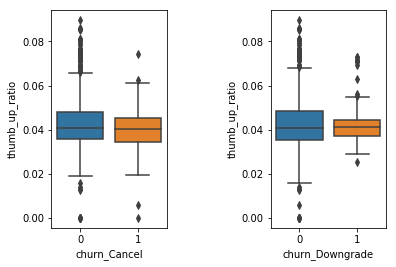

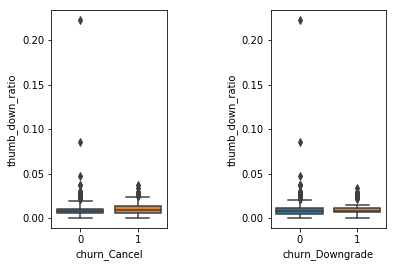

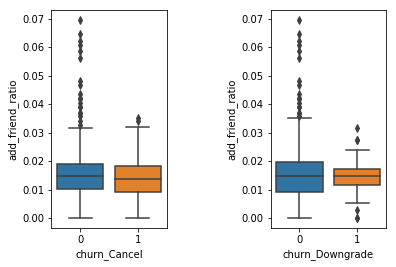

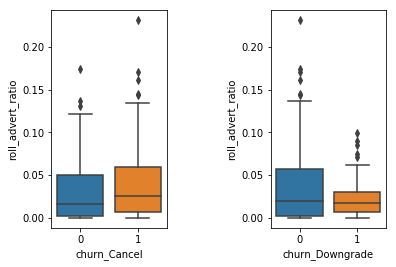

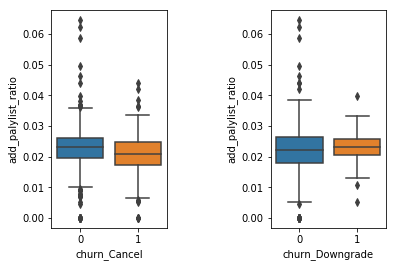

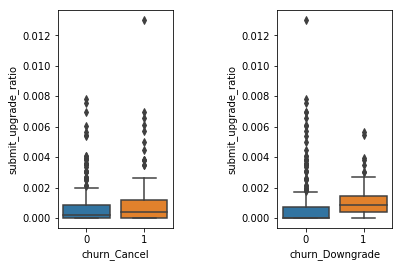

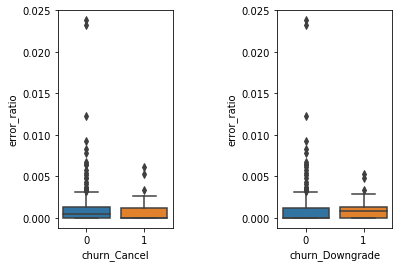

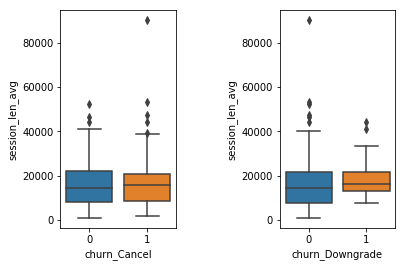

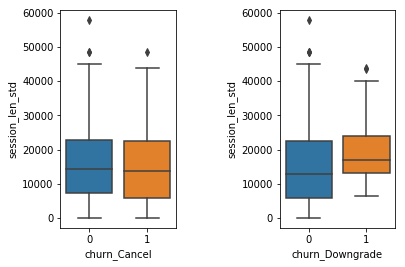

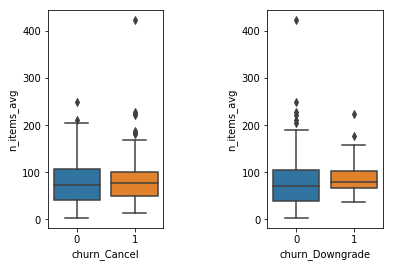

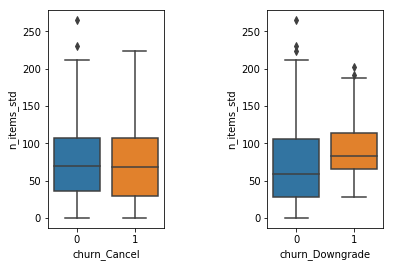

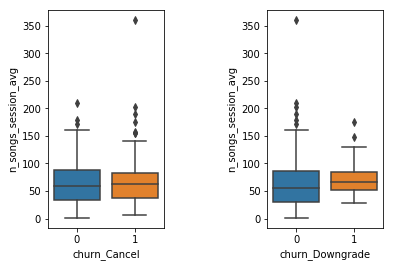

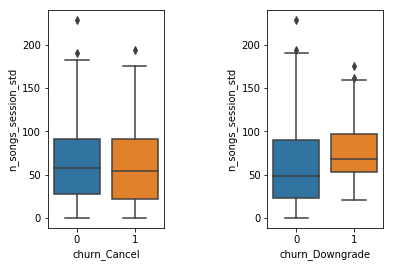

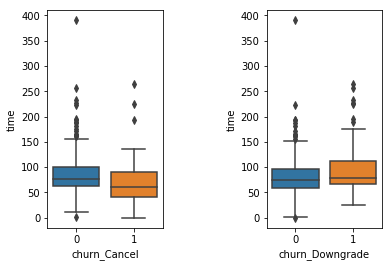

In [29]:
d = df.toPandas()
for c in ['thumb_up_ratio',
 'thumb_down_ratio',
 'add_friend_ratio',
 'roll_advert_ratio',
 'add_palylist_ratio',
 'submit_upgrade_ratio',
 'error_ratio',
 'session_len_avg',
 'session_len_std',
 'n_items_avg',
 'n_items_std',
 'n_songs_session_avg',
 'n_songs_session_std',
 'time']:
    plt.subplot(1,2,1)
    sns.boxplot(x='churn_Cancel', y=c, data=d)
    plt.subplot(1,2,2)
    sns.boxplot(x='churn_Downgrade', y=c, data=d)
    plt.subplots_adjust(wspace=0.9, hspace=0.5)
    plt.show()

Pairwise scatter plots of continuous features show that session length (session_len) and number of items per session (n_item) and number of songs per session (n_songs_session) are highly correlated. Therefore, session length will be kept in the classification model.

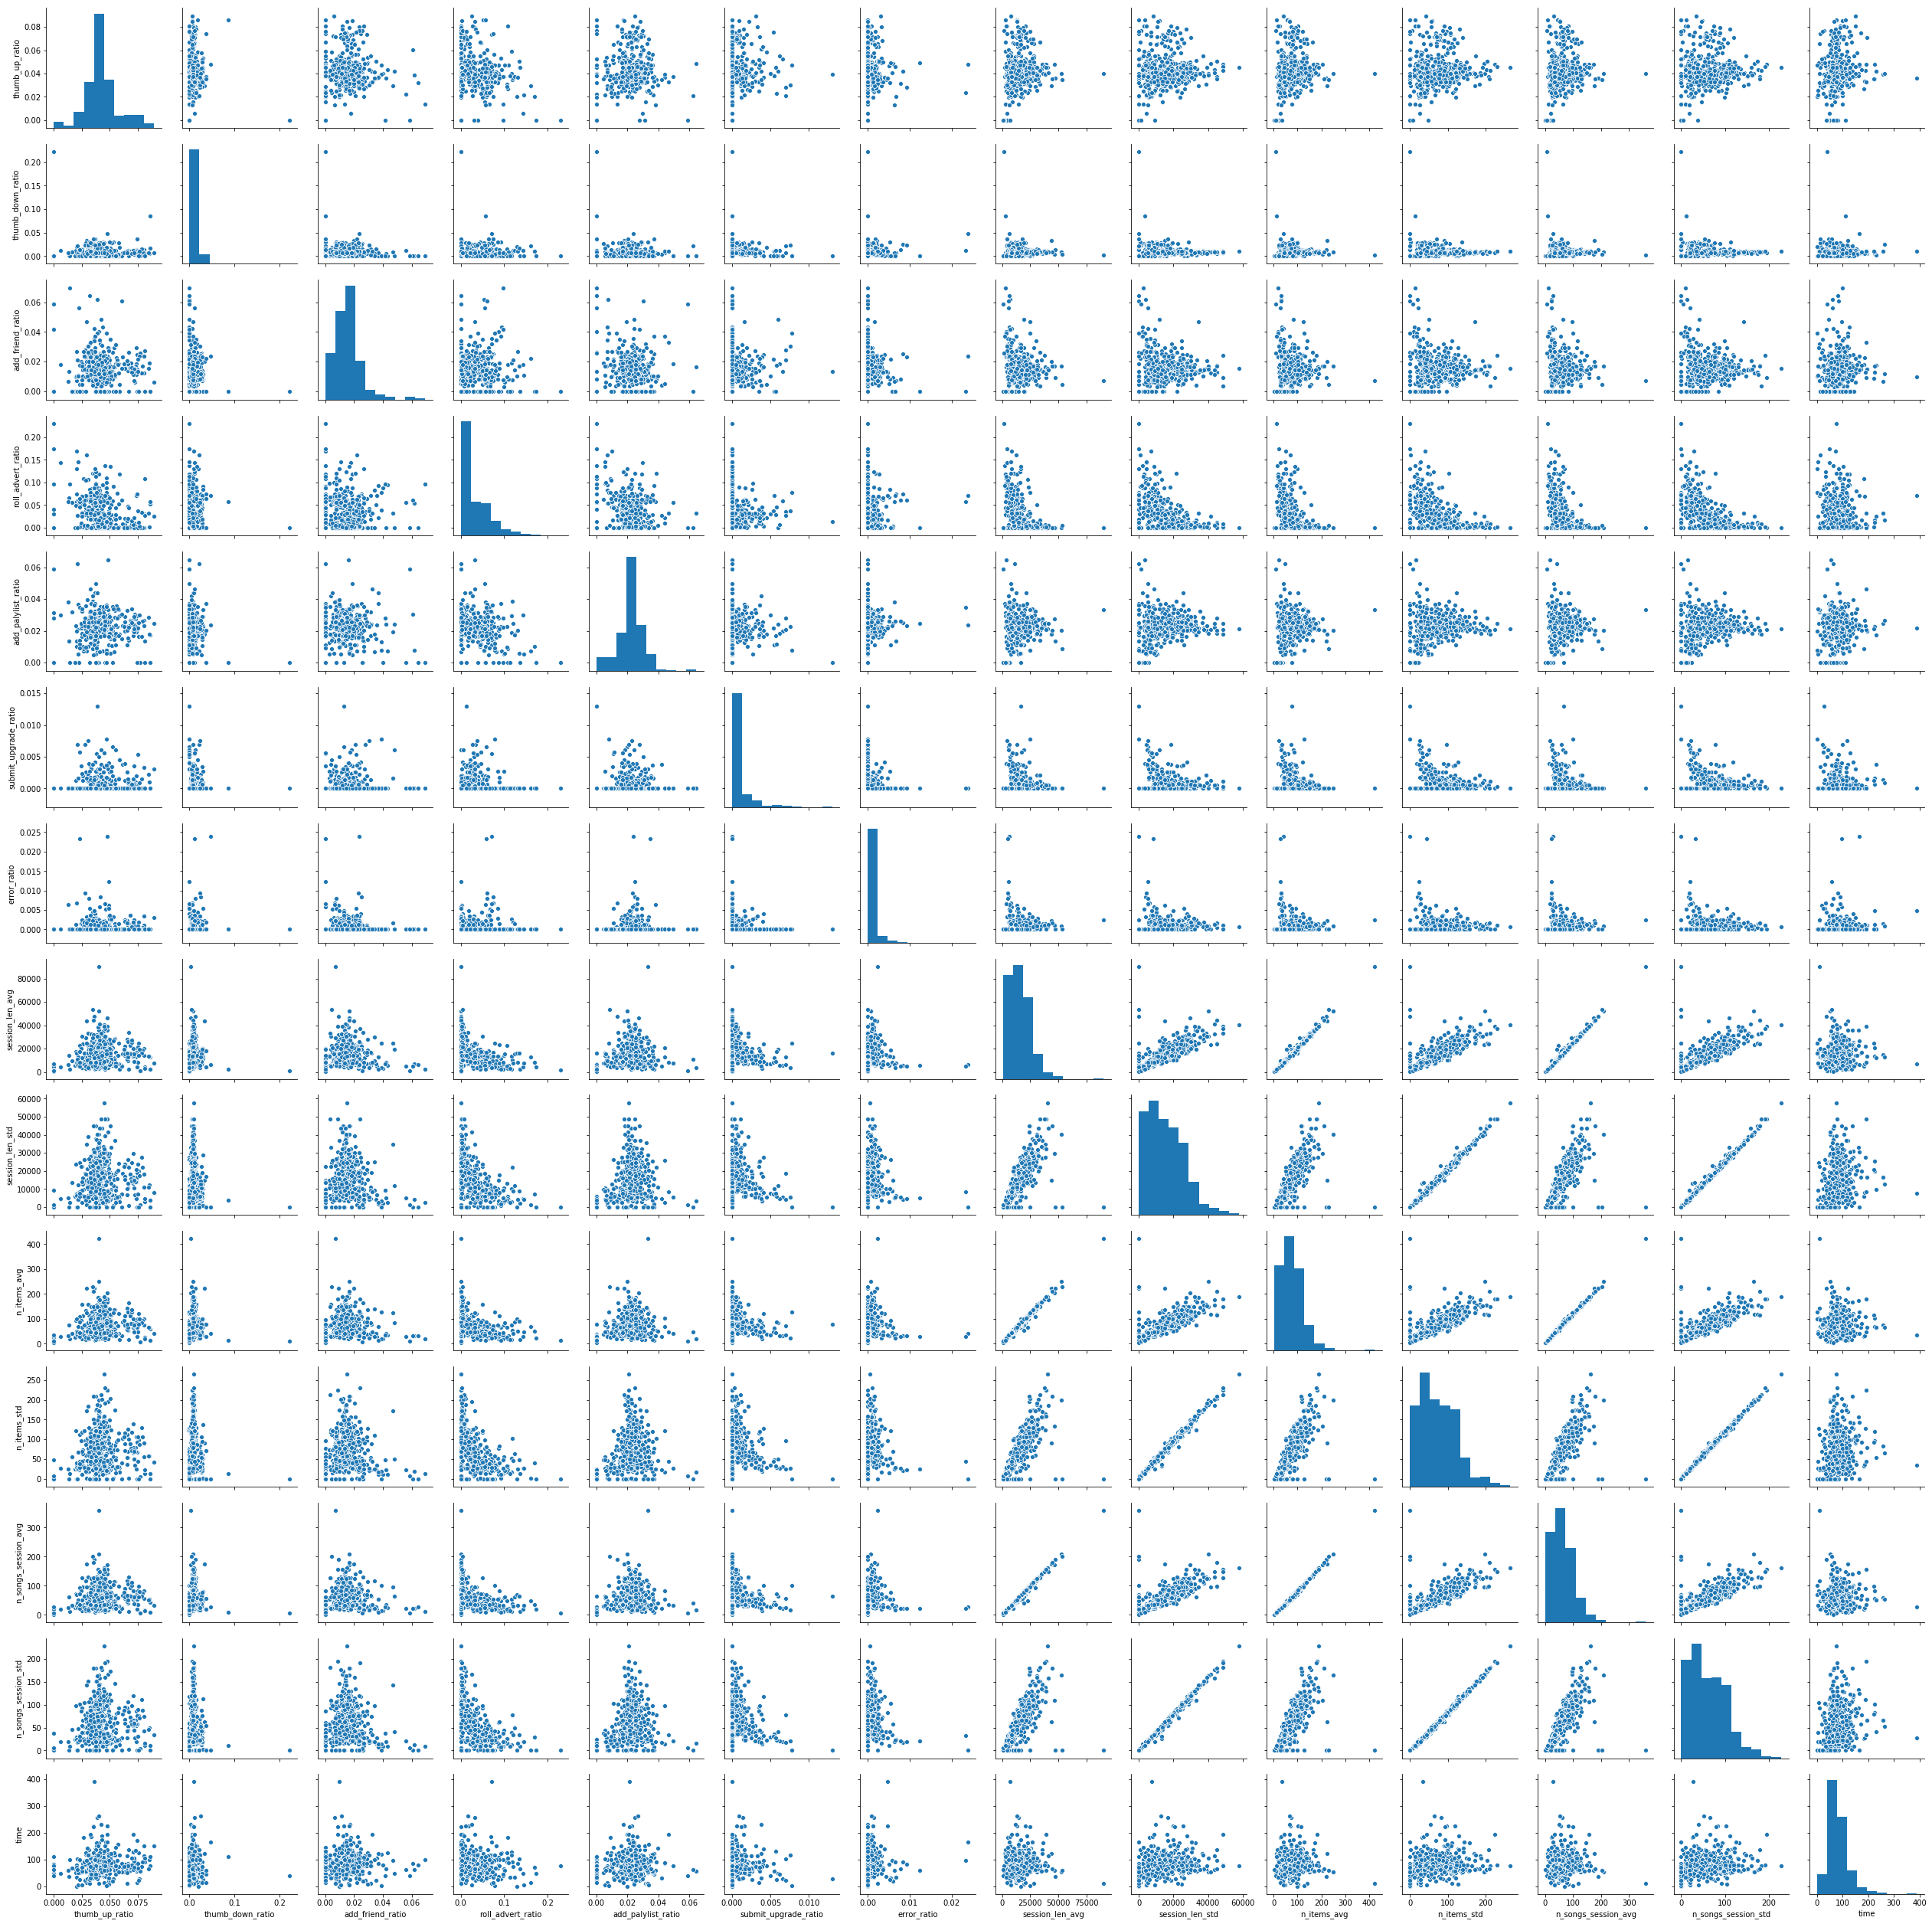

In [30]:
sns.pairplot(d[['thumb_up_ratio',
 'thumb_down_ratio',
 'add_friend_ratio',
 'roll_advert_ratio',
 'add_palylist_ratio',
 'submit_upgrade_ratio',
 'error_ratio',
 'session_len_avg',
 'session_len_std',
 'n_items_avg',
 'n_items_std',
 'n_songs_session_avg',
 'n_songs_session_std',
 'time']]);

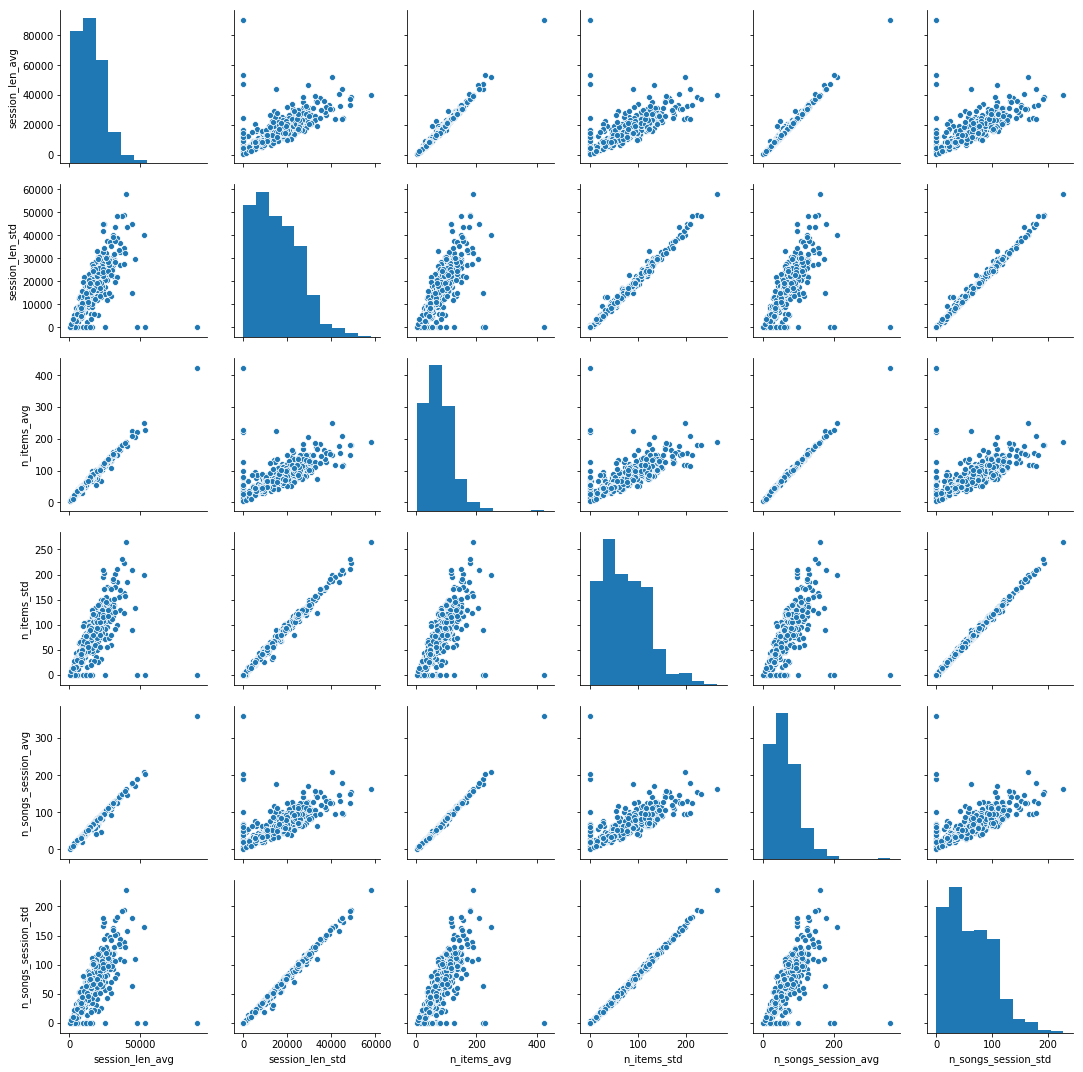

In [31]:
sns.pairplot(d[[
 'session_len_avg',
 'session_len_std',
 'n_items_avg',
 'n_items_std',
 'n_songs_session_avg',
 'n_songs_session_std']]);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Set up pipeline to transform features

In [32]:
inputcols = ['thumb_up_ratio', 'thumb_down_ratio', 'add_friend_ratio','roll_advert_ratio', 
             'add_palylist_ratio', 'submit_upgrade_ratio','error_ratio', 'session_len_avg', 
             'session_len_std','time', 'gendervec', 'status_404', 'devicevec']
#inputcols = ['thumb_up_ratio', 'thumb_down_ratio', 'add_friend_ratio','roll_advert_ratio', 
#             'add_palylist_ratio', 'submit_upgrade_ratio','error_ratio', 'session_len_avg', 
#             'session_len_std','n_items_avg','n_items_std', 'n_songs_session_avg', 
#             'n_songs_session_std','time', 'gendervec', 'status_404', 'devicevec']

gender_indexer = StringIndexer(inputCol='gender', outputCol='genderIndex')
device_indexer = StringIndexer(inputCol='device', outputCol= 'deviceIndex')
encoder = OneHotEncoderEstimator(inputCols=['genderIndex', 'deviceIndex'], outputCols=['gendervec','devicevec'])
assembler = VectorAssembler(inputCols=inputcols, outputCol='features')
pipeline = Pipeline(stages=[gender_indexer, device_indexer, encoder, assembler])

In [33]:
df_train, df_test = df.randomSplit([0.75, 0.25], seed=12)

Transform train and test datasets

In [34]:
datatransform = pipeline.fit(df_train)
train_DF = datatransform.transform(df_train).select('churn_Cancel', 'churn_Downgrade',  'features')
test_DF = datatransform.transform(df_test).select('churn_Cancel', 'churn_Downgrade', 'features')

In [35]:
train_DF.count(), test_DF.count()

(338, 110)

In [36]:
def performance(dataset, label, prediction_label):
    """Calculate classification performance metrics
    Inputs:
        dataset: dataframe of predcition by classification model
        label: column name of true value
        prediction_label: column name of prediction value
    Output:
        (metrics, score): metrics: list of classification performance metrics
                    score: corresponding scores 
    """

    #TP
    sql = '{:s}=1 and {:s}=1'.format(label, prediction_label)
    tp = dataset.filter(sql).count()
    #FN
    sql = '{:s}=1 and {:s}=0'.format(label, prediction_label)
    fn = dataset.filter(sql).count()
    #TN
    sql = '{:s}=0 and {:s}=0'.format(label, prediction_label)
    tn = dataset.filter(sql).count()
    #FP
    sql = '{:s}=0 and {:s}=1'.format(label, prediction_label)
    fp = dataset.filter(sql).count()
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    if (recall+precision) >0:
        f1 = 2*recall*precision/(recall+precision)
    else:
        f1 = 0
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    
    return (['f1', 'Precision', 'Recall', 'Accuracy'], [f1, precision, recall, accuracy])

Three classifiers:logistic regression, random forest and gradient boosting trees

In [37]:
label = 'churn_Cancel'
model = {'LogisticRegression': LogisticRegression(labelCol=label), #logistic regression
         'RandomForest': RandomForestClassifier(labelCol=label), #random forest
         'GBT': GBTClassifier(labelCol=label) } # GBT

Performance of classifiers for churn due to **cancellation**

In [38]:
for m in model:
    pred = model[m].fit(train_DF).transform(test_DF)
    print('------'+m+'------')
    metric, score = performance(pred, label, 'prediction')
    print(' {:s}    {:s} {:s} {:s}\n {:.3f}    {:.3f}  {:.3f}  {:.3f}'.format(*(metric+score)))

------LogisticRegression------
 f1    Precision Recall Accuracy
 0.450    0.818  0.310  0.800
------RandomForest------
 f1    Precision Recall Accuracy
 0.324    0.750  0.207  0.773
------GBT------
 f1    Precision Recall Accuracy
 0.533    0.750  0.414  0.809


Performance of classifiers for churn due to **downgrade**

In [39]:
for m in model:
    model[m].setLabelCol('churn_Downgrade')
    pred = model[m].fit(train_DF).transform(test_DF)
    print('------'+m+'------')
    metric, score = performance(pred, 'churn_Downgrade', 'prediction')
    print(' {:s}    {:s} {:s} {:s}\n {:.3f}    {:.3f}  {:.3f}  {:.3f}'.format(*(metric+score)))

------LogisticRegression------
 f1    Precision Recall Accuracy
 0.071    0.200  0.043  0.764
------RandomForest------
 f1    Precision Recall Accuracy
 0.222    0.750  0.130  0.809
------GBT------
 f1    Precision Recall Accuracy
 0.478    0.478  0.478  0.782


In the classification of churns due to cancellation and downgrade, random forest perform the best in both cases for this particular train and test dataset split. Several different splits have been tried and random forest has robust performance even though its performance may not be the best in some cases. In additon, numerical features do not need to be scaled for tree based models. Finally, random forest is very fast. Therefore we are going to use random forest for the hyperparameter tuning and full data set.

### Define evaluator with f1 score as metric

In [40]:
class Fevaluator:
    def __init__(self, labelCol='label', predictionCol='prediction'):
        self.label = labelCol
        self.prediction = predictionCol
        
    def evaluate(self, dataset):
        _, score = performance(dataset, self.label, self.prediction)
        return score[0]  #f1 score
    def isLargerBetter(self):
        return True

#### Fine tune GBTClassifier

In [44]:
start=time.time()
label = 'churn_Cancel'
gbt_classifier  = GBTClassifier(labelCol=label)
evaluator = Fevaluator(labelCol=label)
grid = ParamGridBuilder() \
.addGrid(gbt_classifier.maxIter, [ 20, 40]) \
.addGrid(gbt_classifier.maxDepth, [5]) \
.addGrid(gbt_classifier.maxBins, [32]) \
.addGrid(gbt_classifier.subsamplingRate, [0.6, 0.7, 0.8, 1]) \
.build()
cv = CrossValidator(estimator=gbt_classifier, estimatorParamMaps=grid, evaluator=evaluator, parallelism=8, seed=12)
cv_model = cv.fit(train_DF)
end = time.time()
print('time = {:.3f}s'.format(end-start))

time = 1288.873s


In [45]:
gbt_best_model = cv_model.bestModel
gbt_pred = gbt_best_model.transform(test_DF)
performance(gbt_pred, 'churn_Cancel', 'prediction')

(['f1', 'Precision', 'Recall', 'Accuracy'],
 [0.5333333333333333, 0.75, 0.41379310344827586, 0.8090909090909091])

In [47]:
cv_model.getEstimatorParamMaps()[np.argmax(cv_model.avgMetrics)]

{Param(parent='GBTClassifier_039e126fbe50', name='maxIter', doc='max number of iterations (>= 0).'): 20,
 Param(parent='GBTClassifier_039e126fbe50', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
 Param(parent='GBTClassifier_039e126fbe50', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 32,
 Param(parent='GBTClassifier_039e126fbe50', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0}

In [48]:
#optimize for churn due to downgrade
start  = time.time()
label = 'churn_Downgrade'
gbt_classifier  = GBTClassifier(labelCol=label)
evaluator = Fevaluator(labelCol=label)
grid = ParamGridBuilder() \
.addGrid(gbt_classifier.maxIter, [ 20, 40]) \
.addGrid(gbt_classifier.maxDepth, [5]) \
.addGrid(gbt_classifier.maxBins, [32]) \
.addGrid(gbt_classifier.subsamplingRate, [0.6, 0.7, 0.8, 1]) \
.build()
cv = CrossValidator(estimator=gbt_classifier, estimatorParamMaps=grid, evaluator=evaluator, parallelism=8, seed=12)
cv_model = cv.fit(train_DF)
end = time.time()
print('time = {:.3f}s'.format(end-start))

time = 1322.703s


In [49]:
gbt_model_downgrade = cv_model.bestModel
gbt_pred_downgrade = gbt_model_downgrade.transform(test_DF)
performance(gbt_pred_downgrade, 'churn_Downgrade', 'prediction')

(['f1', 'Precision', 'Recall', 'Accuracy'],
 [0.5098039215686274,
  0.4642857142857143,
  0.5652173913043478,
  0.7727272727272727])

In [50]:
cv_model.getEstimatorParamMaps()[np.argmax(cv_model.avgMetrics)]

{Param(parent='GBTClassifier_43945f34d35b', name='maxIter', doc='max number of iterations (>= 0).'): 20,
 Param(parent='GBTClassifier_43945f34d35b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
 Param(parent='GBTClassifier_43945f34d35b', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 32,
 Param(parent='GBTClassifier_43945f34d35b', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 0.7}

#### Feature Importance

In [63]:

features = ['thumb_up_ratio', 'thumb_down_ratio', 'add_friend_ratio', 'roll_advert_ratio', 
            'add_palylist_ratio', 'submit_upgrade_ratio', 'error_ratio', 'session_len_avg', 
            'session_len_std', 'time', 'gender', 'status_404', 'device0', 'device1', 'device2', 'device3']
## churn due to cancellation
importance_cancel = pd.DataFrame({'Feature': features, 
                                  'Importance': gbt_best_model.featureImportances.toArray()} )
## churn due to downgrade
importance_downgrade = pd.DataFrame({'Feature': features, 
                                  'Importance': gbt_model_downgrade.featureImportances.toArray()} )

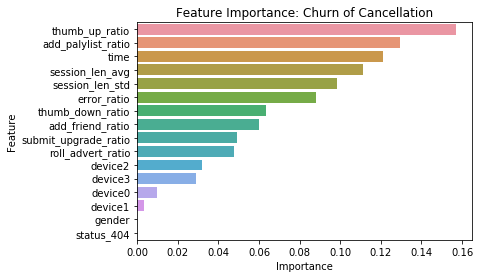

In [64]:
sns.barplot(x='Importance', y='Feature', data=importance_cancel.sort_values(by='Importance', ascending=False));
plt.title('Feature Importance: Churn of Cancellation');

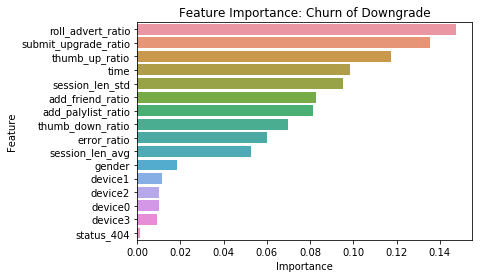

In [65]:
sns.barplot(x='Importance', y='Feature', data=importance_downgrade.sort_values(by='Importance', ascending=False));
plt.title('Feature Importance: Churn of Downgrade');

#### Feature Response

With feature importance, we still don't know 

In [66]:
def response(feature_name, data, model_cancel,model_downgrade, pipeline_model):
    # get the 5%, 25%, 50%, 75%, 95% percentile values of feature
    p = data.select(feature_name).summary('5%', '25%', '50%', '75%', '95%') \
        .select(col(feature_name).cast(FloatType())).collect()
    p = [_[feature_name] for _ in p]
    # copy of data
    dd = spark.createDataFrame(data.collect())
  
    rate_cancel = []
    rate_downgrade = []
    for x in p:
        dd = dd.withColumn(feature_name, lit(x))
        pred = model_cancel.transform(pipeline_model.transform(dd))
        #portion of churn_cancel positive cases in prediciton
        r = pred.select((sum('prediction')/count('prediction')).alias('r')).collect()[0]['r']
        rate_cancel.append(r)
        pred = model_downgrade.transform(pipeline_model.transform(dd))
        #portion of churn_downgrade positive cases in prediciton
        r = pred.select((sum('prediction')/count('prediction')).alias('r')).collect()[0]['r']
        rate_downgrade.append(r)
        
    result = pd.DataFrame({feature_name: p, 
                            'Churn_Cancel_Rate': rate_cancel, 
                            'Churn_Downgrade_Rate': rate_downgrade})
    return result

In [ ]:
response('time', df, gbt_best_model, gbt_model_downgrade, datatransform)

In [68]:
feature_response={}
for feat in features[:10]:
    feature_response[feat] = response(feat, df, gbt_best_model, gbt_model_downgrade, datatransform)

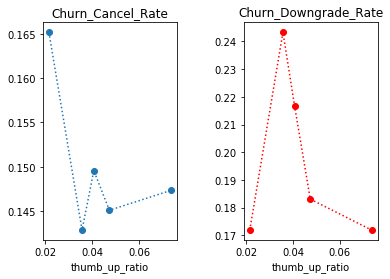

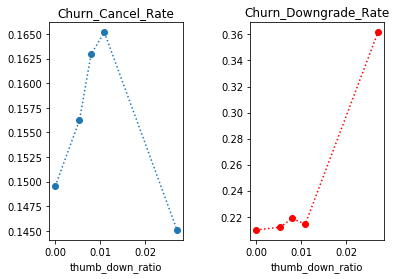

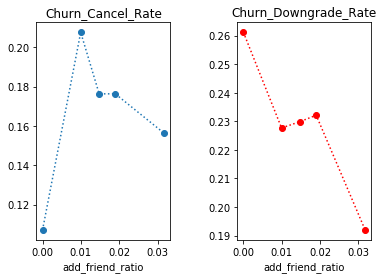

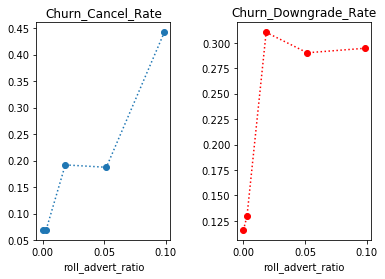

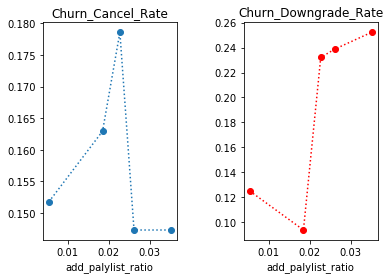

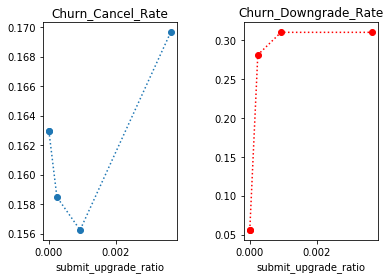

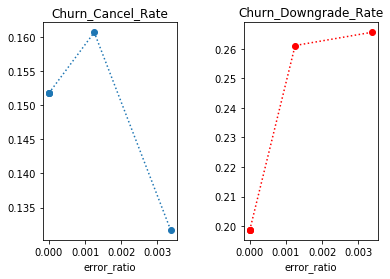

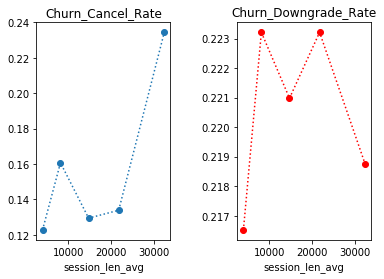

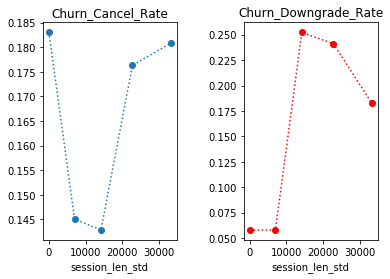

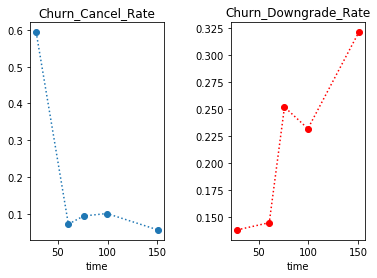

In [69]:
for feat in features[:10]:
    #res = response(feat, df, classifier_model, classifier_model2, datatransform)
    res = feature_response[feat]
    plt.subplot(1,2,1)
    plt.plot(res[feat], res['Churn_Cancel_Rate'], 'o:');
    plt.xlabel(feat);
    plt.title('Churn_Cancel_Rate')
    plt.subplot(1,2, 2)
    plt.plot(res[feat], res['Churn_Downgrade_Rate'], 'ro:');
    plt.xlabel(feat);
    plt.title('Churn_Downgrade_Rate');
    plt.subplots_adjust(wspace=0.5)
    plt.show()

In [53]:
params

['thumb_up_ratio',
 'thumb_down_ratio',
 'add_friend_ratio',
 'roll_advert_ratio',
 'add_palylist_ratio',
 'submit_upgrade_ratio',
 'error_ratio',
 'session_len_avg',
 'session_len_std',
 'time']

#### Sampling to improve model training

In [ ]:
df_train_positive = df_train.filter('churn_cancel=1')
df_train_negative = df_train.filter('churn_cancel=0')

In [ ]:
df_train_positive.select('churn_cancel').groupby('churn_cancel').count().show()

In [ ]:
df_train_negative.select('churn_cancel').groupby('churn_cancel').count().show()

In [ ]:
df_train.select('churn_cancel').groupby('churn_cancel').count().show()

In [ ]:
#over samping churn_cancel

df_train_new = df_train.union(df_train_positive.sample(withReplacement=True, fraction=1.0)) \
                       .union(df_train_positive.sample(withReplacement=True, fraction=1.0))

In [ ]:
df_train_new.select('churn_cancel').groupby('churn_cancel').count().show()

In [ ]:
#datatransform_oversampling = pipeline.fit(df_train_new)
#train_DF_oversampling = datatransform_oversampling.transform(df_train_new).select('churn_Cancel', 'churn_Downgrade',  'features')
#test_DF_oversampling = datatransform.transform(df_test).select('churn_Cancel', 'churn_Downgrade', 'features')

In [ ]:
#label = 'churn_Cancel'
#evalautor = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol=label, metricName='f1')
#model = {'LogisticRegression': LogisticRegression(labelCol=label), #logistic regression
#         'RandomForest': RandomForestClassifier(labelCol=label), #random forest
#         'GBT': GBTClassifier(labelCol=label) } # GBT

In [ ]:
#Without oversmapling of churn 
#for m in model:
#    pred = model[m].fit(train_DF).transform(test_DF)
#    print('------'+m+'------')
#    metric, score = performance(evalautor, pred)
#    print(' {:s}    {:s} {:s} {:s}\n {:.3f}    {:.3f}  {:.3f}  {:.3f}'.format(*(metric+score)))

In [ ]:
#With oversmapling of churn 
#for m in model:
#    pred = model[m].fit(train_DF_oversampling).transform(test_DF_oversampling)
#    print('------'+m+'------')
#    metric, score = performance(evalautor, pred)
#    print(' {:s}    {:s} {:s} {:s}\n {:.3f}    {:.3f}  {:.3f}  {:.3f}'.format(*(metric+score)))

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [97]:
def performance(dataset, label, prediction_label):
    """Calculate classification performance metrics
    Inputs:
        dataset: dataframe of predcition by classification model
        label: column name of true value
        prediction_label: column name of prediction value
    Output:
        (metrics, score): metrics: list of classification performance metrics
                    score: corresponding scores 
    """
    d = dataset.collect()
    cols = [ [x[label], x[prediction_label]] for x in d]
    counts = np.unique(cols, return_counts=True, axis=0)
    tn, fp, fn, tp = counts[1]

    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    if (recall+precision) >0:
        f1 = 2*recall*precision/(recall+precision)
    else:
        f1 = 0
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    
    return (['f1', 'Precision', 'Recall', 'Accuracy'], [f1, precision, recall, accuracy])

In [93]:
performance2(pred, 'churn_Cancel', 'prediction')

(['f1', 'Precision', 'Recall', 'Accuracy'],
 [0.2692307692307692,
  0.30434782608695654,
  0.2413793103448276,
  0.6545454545454545])

In [94]:
performance(pred, 'churn_Cancel', 'prediction')

(['f1', 'Precision', 'Recall', 'Accuracy'],
 [0.2692307692307692,
  0.30434782608695654,
  0.2413793103448276,
  0.6545454545454545])

In [95]:
[tp, fn, tn, fp]

0.5555555555555556

In [ ]:
#
[529, 743, 4067, 205]

In [98]:
start=time.time()
label = 'churn_Cancel'
gbt_classifier  = GBTClassifier(labelCol=label)
evaluator = Fevaluator(labelCol=label)
grid = ParamGridBuilder() \
.addGrid(gbt_classifier.maxIter, [ 20, 40]) \
.addGrid(gbt_classifier.maxDepth, [5]) \
.addGrid(gbt_classifier.maxBins, [32]) \
.addGrid(gbt_classifier.subsamplingRate, [0.6, 0.7, 0.8, 1]) \
.build()
cv = CrossValidator(estimator=gbt_classifier, estimatorParamMaps=grid, evaluator=evaluator, parallelism=8, seed=12)
cv_model = cv.fit(train_DF)
end = time.time()
print('time = {:.3f}s'.format(end-start))

time = 1307.903s
